# Modified CAMPA Tutorial
This tutorial aims to run Modified CAMPA API and repeat Initial CAMPA functions by using Modified CAMPA. All data and pipeline can also be obtained from [Initial CAMPA Tutorial](https://campa.readthedocs.io/en/latest/index.html).

- Download Dataset and Setup
- Training and evaluation process
- Predicting and clustering
- Visualization and analysis

## 1 Download Dataset and Setup

### 1.1 Setup environment
This code is to import the packages that will be used in the following pipeline. Note that the following notebooks assume that you will run them from the same folder that you run this notebook in (CAMPA_DIR). If this is not the case, adjust CAMPA_DIR at the top of each notebook to point to the folder that you run this notebook in. In addition, the `campa.ini` and `example_experiment_params.py` need to be pre-set.

In [ ]:
from pathlib import Path
import os

from campa.tl import (
    Cluster,
    Experiment,
    Estimator_spagft,
    create_cluster_data, 
)
from campa.data import MPPData, create_dataset
from campa.utils import init_logging,load_config
from campa.constants import campa_config

import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# read correct campa_config -- created with setup.ipynb
CAMPA_DIR = Path.cwd()
campa_config.config_fname = CAMPA_DIR / "params/campa.ini"
print(campa_config)
exps = Experiment.get_experiments_from_config("params/example_experiment_params.py")

In [ ]:
from pathlib import Path
import os

from campa.tl import (
    Cluster,
    Experiment,
    Estimator_spagft,
    create_cluster_data, 
)
from campa.data import MPPData, create_dataset
from campa.utils import init_logging,load_config
from campa.constants import campa_config

import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
# init logging with level INFO=20, WARNING=30
init_logging(level=30)
# read correct campa_config -- created with setup.ipynb
CAMPA_DIR = Path.cwd()
campa_config.config_fname = CAMPA_DIR / "params/campa.ini"
print(campa_config)
exps = Experiment.get_experiments_from_config("params/example_experiment_params.py")

### 1.2 Download dataset
Our all data are from CAMPA paper ([Spitzer, H., Berry, S., Donoghoe, M. et al. Learning consistent subcellular landmarks to quantify changes in multiplexed protein maps. Nat Methods 20, 1058–1069 (2023).](https://doi.org/10.1038/s41592-023-01894-z)).
- Download data from [4i Dataset](https://zenodo.org/records/7299516) to a specific file folder
- Setup dataset config files `params/example_data_params.py` and `params/ExampleData_constants.py`
- Create training dataset (It is going to be saved in the `DATASET_DIR` defined by the `ExampleData` data config)

In [ ]:
# Create training dataset
config = load_config("params/example_data_params.py")
print(config.data_params)
create_dataset(config.data_params)

## 2. Training and evaluation process

### 2.1 Using our trained model and subsampled data
Due to the randomness of training neural networks, the latent space might be different, resulting in different clusters, which is also claimed in [the initial CAMPA tutorial](https://campa.readthedocs.io/en/latest/index.html), If you want to fully repeat the experiment result, it is better to download our trained model and subsampled data

- Download data, which can also be obtained from [4i Dataset](https://zenodo.org/records/7299516)
    ```bash
    wget -O example_data/datasetOf4i.tar https://www.dropbox.com/scl/fi/r2tiq6cqd7q6bnepqqlfr/datasetOf4i.tar?rlkey=crdo5tdjinyks82ti9w3bzg8z&dl=0
    cd example_data
    tar -xvf ./datasetOf4i.tar
    ```

- Download subsampled data
    ```bash
    wget -O example_data/example_subsample_data.tar https://www.dropbox.com/scl/fi/rkmo0gvilfluihr8hyss4/example_subsample_data.tar?rlkey=zahj95326pts94lgdjqi2w7m3&dl=0
    cd example_data
    tar -xvf ./example_subsample_data.tar
    ```


- Download calculated `FC` from subsampled data by `SpaGFT`
    ```bash
    wget -O stored_FC/example_FC.tar https://www.dropbox.com/scl/fi/pkqqziq1u64a18vu0hsw3/example_FC.tar\?rlkey\=danr1sre4mj6w2iu5syew9tru\&dl\=0
    cd stored_FC
    tar -xvf ./example_FC.tar
    ```

- Download latent space and pretaind model
    ```bash
    wget -O example_experiments/test/example_dataCondVAE_pert-CC-SpaGFT-Modified.zip https://www.dropbox.com/scl/fi/al2ibjf4mrwtceauk6rgy/CondVAE_pert-CC-SpaGFT-Modified.zip?rlkey=kui1rdhh525ch8678ccy9nuxa&dl=0
    cd example_experiments/test/
    unzip -x ./CondVAE_pert-CC-SpaGFT-Modified.zip
    ```

### 2.2 Totally train from the initialized parameter

In [ ]:
# Fixed random seed
import random
import tensorflow as tf
seed = 43
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1' 

The Estimator_spagft class is modified by SpaGFT from Estimator which handles model setup, training, and prediction. It has the same functions with Estimator class, and you can also run the initial CAMPA by Estimator.

In [ ]:
# training and test
exp = exps[1]
print("Experiment name:", exp.name)
print("Experiment is stored in:", exp.full_path)
est = Estimator_spagft(exp)

The Estimator_spagft.train_model_with_spagft() function is used to train the Modified CAMPA model and the Estimator.train_model() function is used to train the initial CAMPA model.

In [2]:

est.config["training"]["epochs"]=10
history = est.train_model_with_spagft(lamda=0.7,
                                      use_stored_data=False,
                                      stored_data_path=CAMPA_DIR / "stored_FC", 
                                      gft_env_path="/env/spagft_env",
                                      gft_script_path=CAMPA_DIR / "generate_FC_spagft_script.py")
history.to_csv("./history.csv",index=True)

## 3. Predicting and clustering
### 3.1 Cluster resulting latent space with Cluster
To get a quick overview of the generated latent space and the clustering of the latent space, we can use the Cluster class to cluster the evaluation split of the data. To generate the final clustering utilising the entire dataset, sub-setting and clustering the data can be done with the high-level API, using `create_cluster_data`.

In [ ]:
# If you use pretained model and subsampled data, you can skip this step
create_cluster_data(CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/", 
                    subsample=True, frac=0.01, save_dir=CAMPA_DIR /"example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/aggregated/sub-0.01")

This has created a subset of 1% of all pixels in `example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/aggregated/sub-0.01`. This again is readable as `MPPData`. Note that in order to correctly load the `MPPData` here, we have to define the `data_config`, and set the `base_dir` to the `EXPERIMENT_DIR`, as per default, `MPPData` looks for data relative to `DATA_DIR` defined in `data_config`.


Transfer the `MPPData` into `Anadata`, and then using latent embedding of pixel to cluster based on `leiden` algorithm

In [3]:
# load cl
cluster_data_dir = CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/aggregated/sub-0.01"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})

In [4]:
print("obs:", adata.obs.index)
print("var:", adata.var.index)
print("X_latent shape:", adata.obsm["X_latent"].shape)

obs: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '292538', '292539', '292540', '292541', '292542', '292543', '292544',
       '292545', '292546', '292547'],
      dtype='object', length=292548)
var: Index(['01_CDK9_pT186', '01_PABPC1', '02_CDK7', '03_CDK9', '03_RPS6',
       '05_GTF2B', '05_Sm', '07_POLR2A', '07_SETD1A', '08_H3K4me3', '09_CCNT1',
       '09_SRRM2', '10_H3K27ac', '10_POL2RA_pS2', '11_KPNA2_MAX', '11_PML',
       '12_RB1_pS807_S811', '12_YAP1', '13_PABPN1', '13_POL2RA_pS5', '14_PCNA',
       '15_SON', '15_U2SNRNPB', '16_H3', '17_HDAC3', '17_SRSF2', '18_NONO',
       '19_KPNA1_MAX', '20_ALYREF', '20_SP100', '21_COIL', '21_NCL', '00_DAPI',
       '07_H2B'],
      dtype='object', name='name')
X_latent shape: (292548, 16)


In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

# cluster the latent space
sc.pp.neighbors(adata, use_rep="X_latent")
sc.tl.leiden(adata, resolution=0.2, key_added="clustering_res0.2", random_state=0)

/home/jiangyi/.conda/envs/yi/envs/campa_test_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jiangyi/.conda/envs/yi/envs/campa_test_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jiangyi/.conda/envs/yi/envs/campa_test

In [6]:
adata.obs["clustering_res0.2"]

0         0
1         0
2         0
3         0
4         0
         ..
292543    0
292544    0
292545    2
292546    2
292547    0
Name: clustering_res0.2, Length: 292548, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']

In [18]:
np.save(
    os.path.join(cluster_data_dir, "clustering_res0.2"), adata.obs["clustering_res0.2"]
)

Load the `Cluster` object, and export the `Cluster.cluster_mpp` with `MPPData.get_adata` and add the just created clustering to the exported adata object with `add_clustering_to_adata`.

In [3]:
from campa.tl import (
    Cluster,
    add_clustering_to_adata
)
# load cl
cluster_data_dir = CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/aggregated/sub-0.01"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name("clustering_res0.2")
add_clustering_to_adata(
    os.path.join( cluster_data_dir), "clustering_res0.2", adata, cl.cluster_annotation
)

Cannot read with memmap:  /bmbl_data/jiangyi/SpaGFT/campa_develop/campa_file/example_experiments/test/CondVAE_pert-CC-SpaGFT-show-new-apply_version/aggregated/sub-0.01/clustering_res0.2.npy


The following is a UMAP of the latent space coordinates of each pixel. It is useful to check that the clustering algorithm is doing something sensible, and also that the conditions used in the autoencoder don’t end up in different regions of the latent space UMAP (which would indicate that the conditional autoencoder was not able to generate a condition-independent representation). 

/home/jiangyi/.conda/envs/yi/envs/campa_test_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


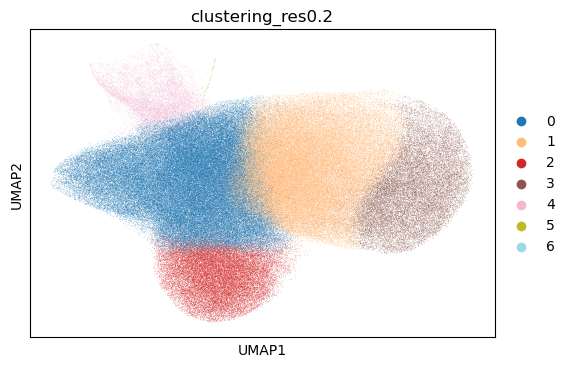

In [4]:
import matplotlib.pyplot as plt
import scanpy as sc
plt.rcParams["figure.figsize"] = [6, 4]
sc.pl.umap(
    adata,
    color="clustering_res0.2",
    vmax="p99",
    ncols=3,
    save = "SpaGFT_clustering_res0.2_umap.png",
)

/home/jiangyi/.conda/envs/yi/envs/campa_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


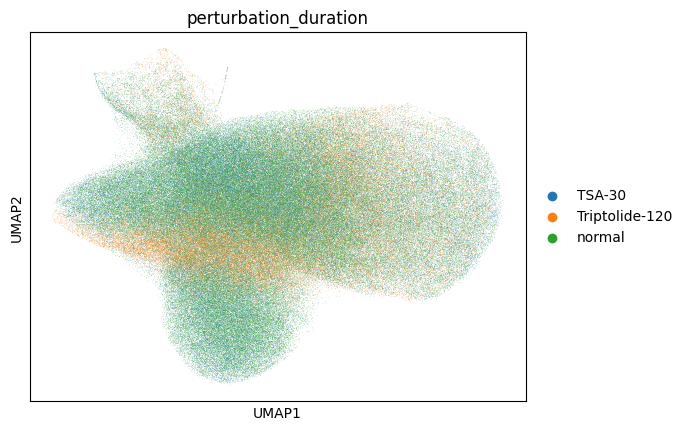

In [7]:
sc.pl.umap(
    adata,
    color=["perturbation_duration"],
    vmax="p99",
    ncols=3,
    save="SpaGFT_perturbation_duration_umap_.png")

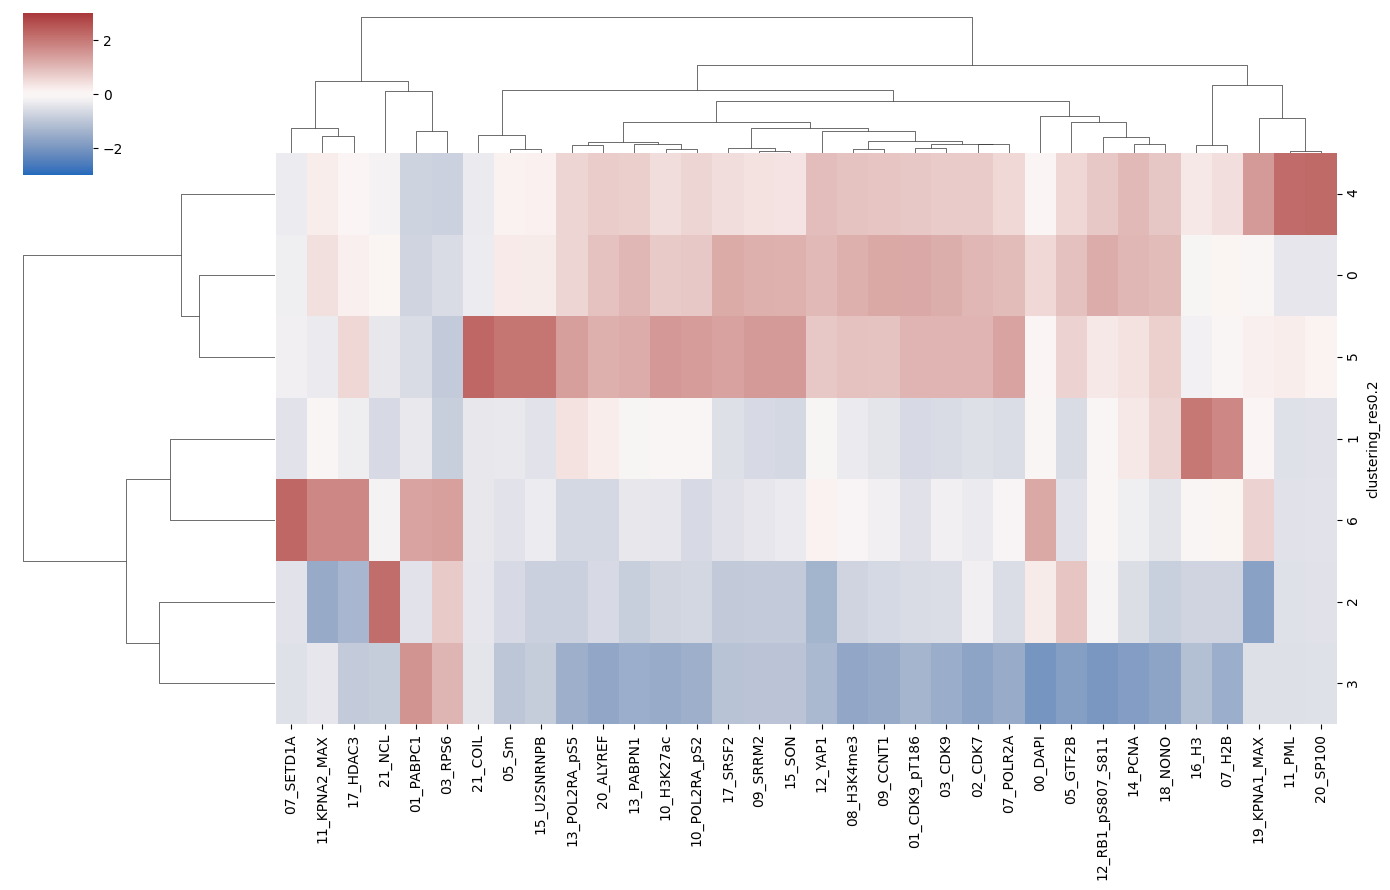

In [13]:
import pandas as pd
import seaborn as sns
cluster_name = "clustering_res0.2"
pixel_values_annotated = pd.concat(
    [
        pd.DataFrame(adata.X, columns=adata.var_names).reset_index(drop=True),
        adata.obs[[cluster_name]].reset_index(drop=True),
    ],
    axis=1,
)
_ = sns.clustermap(
    pixel_values_annotated.groupby(cluster_name).aggregate("mean"),
    z_score=1,
    cmap="vlag",
    figsize=[14, 9],
    vmin=-3,
    vmax=3,
    method="ward",
)

To identify clusters, it can also be very helpful to plot the clusters directly out over some example cells. Using `load_full_data_dict` and `get_clustered_cells`, we can cluster some random cells from each well of the experiment

In [38]:
# If you use pretained model and subsampled data, you can skip this step
from campa.tl import (
    prepare_full_dataset,
)
prepare_full_dataset(CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/", save_dir=CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/aggregated/full_data")

iterating over data dirs ['184A1_unperturbed/I09', '184A1_unperturbed/I11', '184A1_TSA/I16', '184A1_triptolide/I10']
46865/46865 [==============================] - 43s 818us/step


In [ ]:
from campa.tl import (
    # get_clustered_cells,
    Cluster,
    add_clustering_to_adata,
    load_full_data_dict,
)


from campa.pl import annotate_img
import scanpy as sc
from typing import Any, Mapping

def get_clustered_cells(
    mpp_datas: Mapping[str, MPPData], cl: Cluster, cluster_name: str, num_objs: int = 5 , objs_ids: list = None,
) -> Mapping[str, Mapping[str, MPPData]]:
    cl.set_cluster_name(cluster_name)
    res: dict[str, dict[str, Any]] = {cluster_name: {}, cluster_name + "_colored": {}} 
    mpp_data_list: dict[str, dict[str, Any]] = {cluster_name: {}} 
    for data_dir, mpp_data in mpp_datas.items():
        rng = np.random.default_rng(seed=42)
        if objs_ids == None:
            if num_objs>0:
                obj_ids = rng.choice(mpp_data.unique_obj_ids, num_objs, replace=False)
            else:
                obj_ids = mpp_data.unique_obj_ids
        else:
            obj_ids = objs_ids
        # print(obj_ids)
        # subset mpp_data to obj_ids
        sub_mpp_data = mpp_data.subset(obj_ids=obj_ids, copy=True)
        # project_clustering
 
        sub_mpp_data = cl.project_clustering(sub_mpp_data)
        mpp_data_list[cluster_name][data_dir] = sub_mpp_data.copy()
        # if only need colored cells, can pass annotation_kwargs to get_object_imgs
        res[cluster_name][data_dir] = sub_mpp_data.get_object_imgs(
            data=cluster_name
        )  # annotation_kwargs={'color': True, 'annotation': cl.cluster_annotation})
        res[cluster_name + "_colored"][data_dir] = [
            annotate_img(img, annotation=cl.cluster_annotation, from_col=cluster_name, color=True)
            for img in res[cluster_name][data_dir]
        ]
    return res, mpp_data_list



def find_obj_with_id(exp, mpp_datas, cl, cluster_number = 7, cluster_name ="clustering_res0.2", obj_select_list = [367420], sample_id = "184A1_unperturbed/I11",save_root="./"):
    cluster_5_freq_in = []
    cluster_6_freq_in = []
    clusters_pixel = []
    cluster_name_list = [str(cvn) for cvn in range(cluster_number)]
    for index, value  in enumerate(obj_select_list):
        example_cells = {}
        res, mpp_data_list = get_clustered_cells({sample_id:mpp_datas[sample_id]}, cl, cluster_name, objs_ids=[value] ,num_objs=0)
        example_cells.update(res)
        i = 0
        select_data = mpp_data_list[cluster_name][sample_id].get_adata("mpp")
        select_data.X = np.array(select_data.X)

        v_res = res[cluster_name][sample_id][0]
        
        clusters, freq_in = np.unique([v for v in np.ravel(v_res) if v in cluster_name_list],return_counts=True)
        clusters_pixel.append(np.sum(freq_in))
        title = False
        if "5" in clusters:
            print(f"{'*'*50}__________{value}__________{'*'*50}")
            title =True
            cluster_5_freq_in.append(freq_in[np.where(clusters=="5")][0])
            print(f"5---{value}: ", freq_in[np.where(clusters=="5")[0]])
        else:
            cluster_5_freq_in.append(0)
        if "6" in clusters:
            if not title:
                print(f"{'*'*50}__________{value}__________{'*'*50}")
            cluster_6_freq_in.append(freq_in[np.where(clusters=="6")][0])
            print(f"6---{value}: ", freq_in[np.where(clusters=="6")[0]])
        else:
            cluster_6_freq_in.append(0)
        
        fig, ax = plt.subplots()
        ax.imshow(example_cells[f"{cluster_name}_colored"][sample_id][0])
        ax.axis("off")
        fig.savefig(f"{save_root}/{value}.cluster.fig.svg",dpi=1000)
        fig.savefig(f"{save_root}/{value}.cluster.fig.png",dpi=1000)
        select_data.write_h5ad(f"{save_root}/{value}.adata.h5ad")

        x, y = [],[]
        v = [[] for v_array in range(7)]
        res[cluster_name][sample_id][0].shape
        for x_i,x_v in enumerate(res[cluster_name][sample_id][0]):
            for y_i,y_v in enumerate(x_v):
                if y_v[0] in cluster_name_list:
                    x.append(x_i)
                    y.append(y_i)
                    for v_v in cluster_name_list:
                        if v_v == y_v[0]:
                            v[int(v_v)].append(1)
                        else:
                            v[int(v_v)].append(0)
            dict_binary = { str(vvv) : v[vvv] for vvv in range(7)}
            sc.AnnData(X = np.array(v).T  , obs = {"x":x,"y":y}).write_h5ad(f"{save_root}/{value}.adata.pixel.h5ad")
            print(f"{'*'*50}__________________________{'*'*50}")
    return cluster_5_freq_in, cluster_6_freq_in, clusters_pixel 


# load cl
cluster_data_dir = CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/aggregated/sub-0.01"
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cluster_name = "clustering_res0.2"
# get adata object
adata = cl.cluster_mpp.get_adata(X="mpp", obsm={"X_latent": "latent", "X_umap": "umap"})
# add clustering and colormap (from cluster_name_annotation.csv) to adata
cl.set_cluster_name(cluster_name)
add_clustering_to_adata(
    os.path.join( cluster_data_dir), cluster_name, adata, cl.cluster_annotation
)


**************************************************__________367420__________**************************************************
5---367420:  [95]
6---367420:  [4]
**************************************************__________________________**************************************************


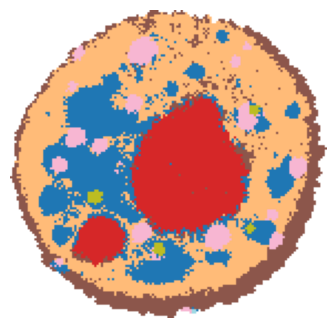

In [127]:

exp = Experiment.from_dir(CAMPA_DIR / "example_experiments/test/CondVAE_pert-CC-SpaGFT-Modified/")
mpp_datas = load_full_data_dict(exp,keys = ["x","y","obj_ids","latent", "mpp"])

_, _, _ = find_obj_with_id(exp, mpp_datas, cl, cluster_number = 7, cluster_name ="clustering_res0.2", obj_select_list = [367420], sample_id = "184A1_unperturbed/I11")